In [1]:
'''
Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
'''

'\nPredict the price of the Uber ride from a given pickup point to the agreed drop-off location.\nPerform following tasks:\n1. Pre-process the dataset.\n2. Identify outliers.\n3. Check the correlation.\n4. Implement linear regression and random forest regression models.\n5. Evaluate the models and compare their respective scores like R2, RMSE, etc.\n'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [9]:
data = pd.read_csv("/content/uber.csv")
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [10]:
data.shape


(200000, 9)

In [5]:
data.isnull().sum()

,0
Unnamed: 0,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,1
passenger_count,1


In [11]:
data.drop(columns='Unnamed: 0', inplace=True)
data = data.dropna()
data.isnull().sum()

,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [12]:
data.drop_duplicates(inplace=True)
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [13]:
data = data[data['fare_amount']> 0]
data["pickup_datetime"] = data["pickup_datetime"].apply(lambda x:[x[0:10] for x in x.split(' ')])
data["pickup_datetime"] = data["pickup_datetime"].apply(lambda x:x[0])
data["pickup_datetime"] = pd.DatetimeIndex(data["pickup_datetime"]).year

In [14]:
data.drop(columns=['key','pickup_datetime'],inplace=True)

X = data.drop(['fare_amount'], axis=1)
y = data['fare_amount']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=0)

In [15]:
data.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.010468,-0.008489,0.009208,-0.011250,0.010422
pickup_longitude,0.010468,1.000000,-0.816434,0.833132,-0.846449,-0.000488
pickup_latitude,-0.008489,-0.816434,1.000000,-0.774880,0.702450,-0.001500
dropoff_longitude,0.009208,0.833132,-0.774880,1.000000,-0.916971,-0.000104
dropoff_latitude,-0.011250,-0.846449,0.702450,-0.916971,1.000000,-0.000514
passenger_count,0.010422,-0.000488,-0.001500,-0.000104,-0.000514,1.000000


<Axes: ylabel='fare_amount'>

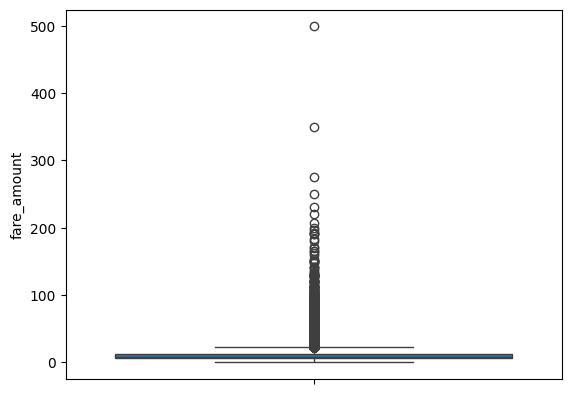

In [16]:
sns.boxplot(data['fare_amount'])

In [17]:
Q1 = np.percentile(data['fare_amount'], 25, interpolation= 'midpoint')
Q3 = np.percentile(data['fare_amount'], 25, interpolation= 'midpoint')
print(Q1,Q3)

6.0 6.0


<Axes: ylabel='fare_amount'>

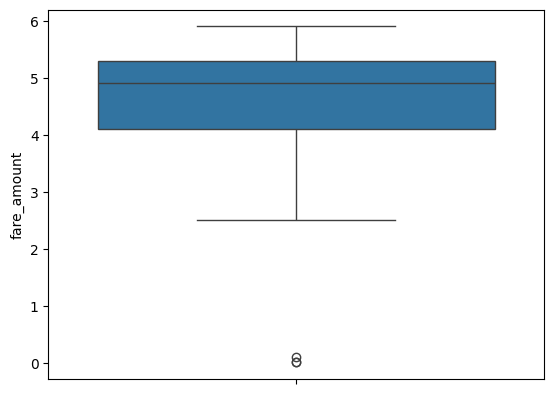

In [18]:
data.drop(data[data['fare_amount'].values>=6.0].index, inplace=True)
sns.boxplot(data['fare_amount']) ## See again

In [19]:
linear = LinearRegression()
linear.fit(x_train,y_train)

LinearRegression()

In [20]:
y_pred_linear = linear.predict(x_test)
def evaluate_model(y_true, y_pred, model_name):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} RMSE: {rmse:.2f}")
    print(f"{model_name} R-squared (R2): {r2:.2f}")

print("Linear regression Model")
evaluate_model(y_test, y_pred_linear, "Linear Regression")

Linear regression Model
Linear Regression RMSE: 9.82
Linear Regression R-squared (R2): 0.00


In [21]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
y_pred_rf = rf_model.predict(x_test)
def evaluate_model(y_true, y_pred, model_name):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} RMSE: {rmse:.2f}")
    print(f"{model_name} R-squared (R2): {r2:.2f}")

print("\nRandom Forest Regression Model:")
evaluate_model(y_test, y_pred_rf, "Random Forest Regression")


Random Forest Regression Model:
Random Forest Regression RMSE: 4.93
Random Forest Regression R-squared (R2): 0.75
